In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import os, sys
curruser = os.environ.get('USER')
sys.path.insert(0, './../src/')
sys.path.insert(0, '/home/{}/notebooks/support_library/'.format(curruser)) 
sys.path.insert(0, '/home/{}/python35-libs/lib/python3.5/site-packages/'.format(curruser))
# sys.path.insert(0, '/home/ufimtsev1-ys_ca-sbrf-ru/notebooks/labdata/lib/')

import re 
import joblib
import gc
import numpy as np
import pandas as pd
import subprocess
# from sshloader import Ssh
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import ast
from time import time

%matplotlib inline
pd.options.display.max_columns = 1000


# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

from csv import QUOTE_ALL 

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
# tqdm_notebook.pandas()

import feature_importance
from plot import Plot
from  forward_permutationFE_cv import ForwardPermutationFECV 

import sklearn
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, make_scorer, confusion_matrix, get_scorer
            
from sklearn.preprocessing import binarize, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion


print(sklearn.__version__)
print(xgboost.__version__)
print(pd.__version__)

0.22.2.post1
0.81
0.25.3


In [3]:
def get_metrics(y_pred, y, average='binary'):
    print(classification_report(y, y_pred, digits=5, ))
    recall = recall_score(y, y_pred, average=average)
    precision=precision_score(y, y_pred,average=average)
    f1=f1_score(y, y_pred,average=average)
    
    return recall, precision, f1

def feature_impotance(model, X_train, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))
    
    fig, ax = plt.subplots(figsize=(9,12))
    #ax = plt.axes()
    sns.barplot(x=imp, y=names, palette=sns.color_palette('YlGn', 2), ax=ax)
    ax.set_title('Top ' + str(count_top_features) + ' important features')
    plt.show()

## Copy data from HDFs and read ones as pandas into memory

In [ ]:
# specify your username and password:
__username = 'ufimtsev1-ys_ca-sbrf-ru'
__pass     = getpass.getpass()
jupyterPass = 'myjupyter'
jupyterPort ='8100'

In [ ]:
_ssh = Ssh(username=__username, 
           password=__pass, 
           host='februs11.ca.sbrf.ru',
           verbosity=1)
_ssh.setup()      

stdin,stdout,stderr=_ssh.ssh.exec_command("cd /home/{username}; hdfs dfs -get /user/{username}/csv/* \
                                              /home/{username}/notebook/sendsay_model/csv/".format(username=__username))
outlines=stderr.readlines()
resp=''.join(outlines)
print(resp)

In [6]:
datacsv = []
cmd = "hdfs dfs -ls /user/'%s'/csv/ | awk '{print $8}'" % curruser
hdfs_files = str(subprocess.check_output(cmd, shell=True)).strip().split('\\n')
for hfiles in hdfs_files:
    if hfiles.endswith('csv'):
        print(hfiles)
        subprocess.call(['hdfs', 'dfs', '-get', '-p', hfiles, '/home/{}/notebook/sendsay_model/csv/'.format(curruser)])
        datacsv.append(hfiles)

/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-05b80dce-e559-4fcc-b46d-c21e8755fdcd-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-13989770-51d9-4a34-9486-f082520796ad-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-2d03538f-8fa5-4167-a3d3-892d5d91fc11-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-337a96d8-98ce-4233-8ac2-5cfe844b5136-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-5799ae44-0b33-460d-9690-09856f9ae02b-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-70b4cb69-d6ab-4d11-9948-cda8eb654782-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-84586571-0a34-4fe6-a69d-5fc728f32ca9-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-a9770f0a-e8c6-43ae-854d-cd04c12522a4-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-b7624993-460a-40c2-966f-65b791eb9f35-c000.csv
/user/ufimtsev1-ys_ca-sbrf-ru/csv/part-00000-bcd86821-0ebe-40d9-a2a9-e680a055186c-c000.csv


## Pandas Reading

In [4]:
with open('./csv/df_cols', 'r') as fin:
    res = fin.readlines()
cols = [re.sub('\\n','',line) for line in res]

In [5]:
path = '/tmp/sendsay_csv/'
filelist = os.listdir(path)
filelist

['part-00000-05b80dce-e559-4fcc-b46d-c21e8755fdcd-c000.csv',
 'part-00000-13989770-51d9-4a34-9486-f082520796ad-c000.csv',
 'part-00000-2d03538f-8fa5-4167-a3d3-892d5d91fc11-c000.csv',
 'part-00000-337a96d8-98ce-4233-8ac2-5cfe844b5136-c000.csv',
 'part-00000-5799ae44-0b33-460d-9690-09856f9ae02b-c000.csv',
 'part-00000-70b4cb69-d6ab-4d11-9948-cda8eb654782-c000.csv',
 'part-00000-84586571-0a34-4fe6-a69d-5fc728f32ca9-c000.csv',
 'part-00000-b7624993-460a-40c2-966f-65b791eb9f35-c000.csv',
 'part-00000-bcd86821-0ebe-40d9-a2a9-e680a055186c-c000.csv',
 'part-00000-a9770f0a-e8c6-43ae-854d-cd04c12522a4-c000.csv']

## Fetch buckets and concat ones iteratiwely

In [6]:
df = pd.read_csv(filepath_or_buffer = path+filelist[1], 
                 sep = ';', nrows=0, 
                 engine='python',
                 dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                 ) 

In [7]:
%%time
for data in tqdm_notebook(filelist):
    if data.endswith('csv'):
        print("...working with file--> {}".format(data))
        dftmp = pd.read_csv(filepath_or_buffer = path+data, 
                         sep = ';', nrows=None, 
                         engine='python',
                         dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                         ) 


        df = pd.concat([df,dftmp], ignore_index=True)
        del dftmp
        gc.collect()
        print(df.shape)  

...working with file--> part-00000-05b80dce-e559-4fcc-b46d-c21e8755fdcd-c000.csv
(628380, 439)
...working with file--> part-00000-13989770-51d9-4a34-9486-f082520796ad-c000.csv
(1256760, 439)
...working with file--> part-00000-2d03538f-8fa5-4167-a3d3-892d5d91fc11-c000.csv
(1885139, 439)
...working with file--> part-00000-337a96d8-98ce-4233-8ac2-5cfe844b5136-c000.csv
(2513519, 439)
...working with file--> part-00000-5799ae44-0b33-460d-9690-09856f9ae02b-c000.csv
(3141899, 439)
...working with file--> part-00000-70b4cb69-d6ab-4d11-9948-cda8eb654782-c000.csv
(3770279, 439)
...working with file--> part-00000-84586571-0a34-4fe6-a69d-5fc728f32ca9-c000.csv
(4398659, 439)
...working with file--> part-00000-b7624993-460a-40c2-966f-65b791eb9f35-c000.csv
(5027040, 439)
...working with file--> part-00000-bcd86821-0ebe-40d9-a2a9-e680a055186c-c000.csv
(5655420, 439)
...working with file--> part-00000-a9770f0a-e8c6-43ae-854d-cd04c12522a4-c000.csv
(6283800, 439)

CPU times: user 43min 52s, sys: 6min 16s

## Check initial class banance

In [89]:
neg, pos = df.groupby(['target'])['target'].count().tolist()
bal = pos/neg*100
bal

17.68383206035103

## Split

In [8]:
X_train, X_test, y_train, y_test = \
train_test_split(df.drop(['target'], axis=1), df.target, 
                 stratify = df.target,
                 random_state=42, shuffle=True, test_size=0.2)

## Check class balance in train df after stratified split operation

In [36]:
neg, pos = y_train.count() - y_train.sum(), y_train.sum()
bal = pos/neg*100
bal

17.68382655035561

## Make a Prediction Using Model PreTrained on Historical Data

In [14]:
for file in os.listdir('./pkl'):
    if 'xgb_cls_tuned_pipe_wFT_200820' in file:
        print("...load xgb model from--> {}".format(file))
        xgb = joblib.load('./pkl/{}'.format(file))

...load xgb model from--> xgb_cls_tuned_pipe_wFT_200820.pkl


In [15]:
xgb_params = xgb.get_params()
xgb_params = dict(xgb_params,**{'n_jobs'   : 15,
                                'verbosity': 1})

In [17]:
try:
    y_pred = xgb.predict(X_test.astype(dtype=np.float32))
except ValueError as err:
    colsstr = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
    getcolslist = list(ast.literal_eval(colsstr[1:-1]))
    X_test = X_test[getcolslist]       
    y_pred = xgb.predict(X_test.astype(dtype=np.float32))
    
recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

del X_train, X_test, y_train, y_test

              precision    recall  f1-score   support

           0    0.87035   0.92436   0.89654   1067912
           1    0.34103   0.22136   0.26846    188848

    accuracy                        0.81872   1256760
   macro avg    0.60569   0.57286   0.58250   1256760
weighted avg    0.79081   0.81872   0.80216   1256760

Hold Out: 
Precision: 0.34103, Recall: 0.22136, F_1: 0.26846


## Check for constant cols again

In [16]:
zero_std_cols = df.columns[df.std(axis=0) == 0.].values.tolist()
df.drop(columns=zero_std_cols, axis=1, inplace=True)
df.shape

(6283800, 406)

## Feature-by-feature distribution similarity
Next let us try to look at the problem feature-by-feature, and perform Kolmogorov-Smirnov tests to see if the distribution in test and training set is similar.
* use the function [scipy.stats.ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp) from scipy to run the tests.

For all those features where the distributions are highly distinguishable, we may benefit from ignoring those columns, so as to avoid overfitting on training data. In the following just identify those columns, and plot the distributions as a sanity check for some of the features

In [18]:
from scipy.stats import ks_2samp

In [19]:
def get_diff_columns(train_df, test_df, show_plots=True, show_all=False, threshold=0.1, kde=False):
    """Use KS to estimate columns where distributions differ a lot from each other"""

    # Find the columns where the distributions are very different
    diff_data = []
    for col in tqdm(train_df.columns):
        statistic, pvalue = ks_2samp(
            train_df[col].values, 
            test_df[col].values
        )
        if pvalue <= 0.05 and np.abs(statistic) >= threshold:
            diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 3)})
   
    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data)
    if len(diff_df) > 0:
        diff_df.sort_values(by='statistic', ascending=False, inplace=True)

        if show_plots:
            # Let us see the distributions of these columns to confirm they are indeed different
            n_cols = 3
            if show_all:
                n_rows = int(len(diff_df) / 3)
            else:
                n_rows = 7
            _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
            axes = [x for l in axes for x in l]

            # Create plots
            for i, (_, row) in enumerate(diff_df.iterrows()):
                if i >= len(axes):
                    break
                if not kde:    
                    extreme = np.max(np.abs(train_df[row.feature].tolist() + test_df[row.feature].tolist()))
                    train_df.loc[:, row.feature].hist(
                        ax=axes[i], alpha=0.5, label='Train', density=True,
                        bins=np.arange(-extreme, extreme, 0.05)
                    )
                    test_df.loc[:, row.feature].hist(
                        ax=axes[i], alpha=0.5, label='Test', density=True,
                        bins=np.arange(-extreme, extreme, 0.05)
                    )
                    axes[i].legend()
                else:
                    sns.distplot(train_df.loc[:, row.feature], label='Train', 
                                 hist=False, kde=True, norm_hist=True, ax=axes[i])
                    sns.distplot(test_df.loc[:, row.feature], label='Test', 
                                 hist=False, kde=True, norm_hist=True, ax=axes[i])

                axes[i].set_title('Statistic = {}, p = {}'.format(row.statistic, row.p))
                axes[i].set_xlabel('{}'.format(row.feature))


            plt.tight_layout()
            plt.show()
        
    return diff_df

### Cols Segmentation

In [9]:
import re
pattern = re.compile(r'.*_m\d{1}1')
ftcols = [col for col in list(df.columns) if '_FT_' in col]
respcols = [col for col in list(df.columns) if len(pattern.findall(col))!=0]
ml360cols = list(set(list(df.columns)) - set(respcols) - set(ftcols))

cols_filtered = list(set(respcols+ml360cols)-set(['target']))

In [20]:
# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(X_train[cols_filtered], X_test[cols_filtered], threshold=0.1, show_all=True, kde=True)

100%|██████████| 105/105 [01:11<00:00,  1.47it/s]


## Pearson Correlation Map

In [60]:
# impotant_columns = [col[0] for col in sorted(zip(df.columns, xgb.feature_importances_), key=lambda x: x[1], reverse=True)[:50]] 

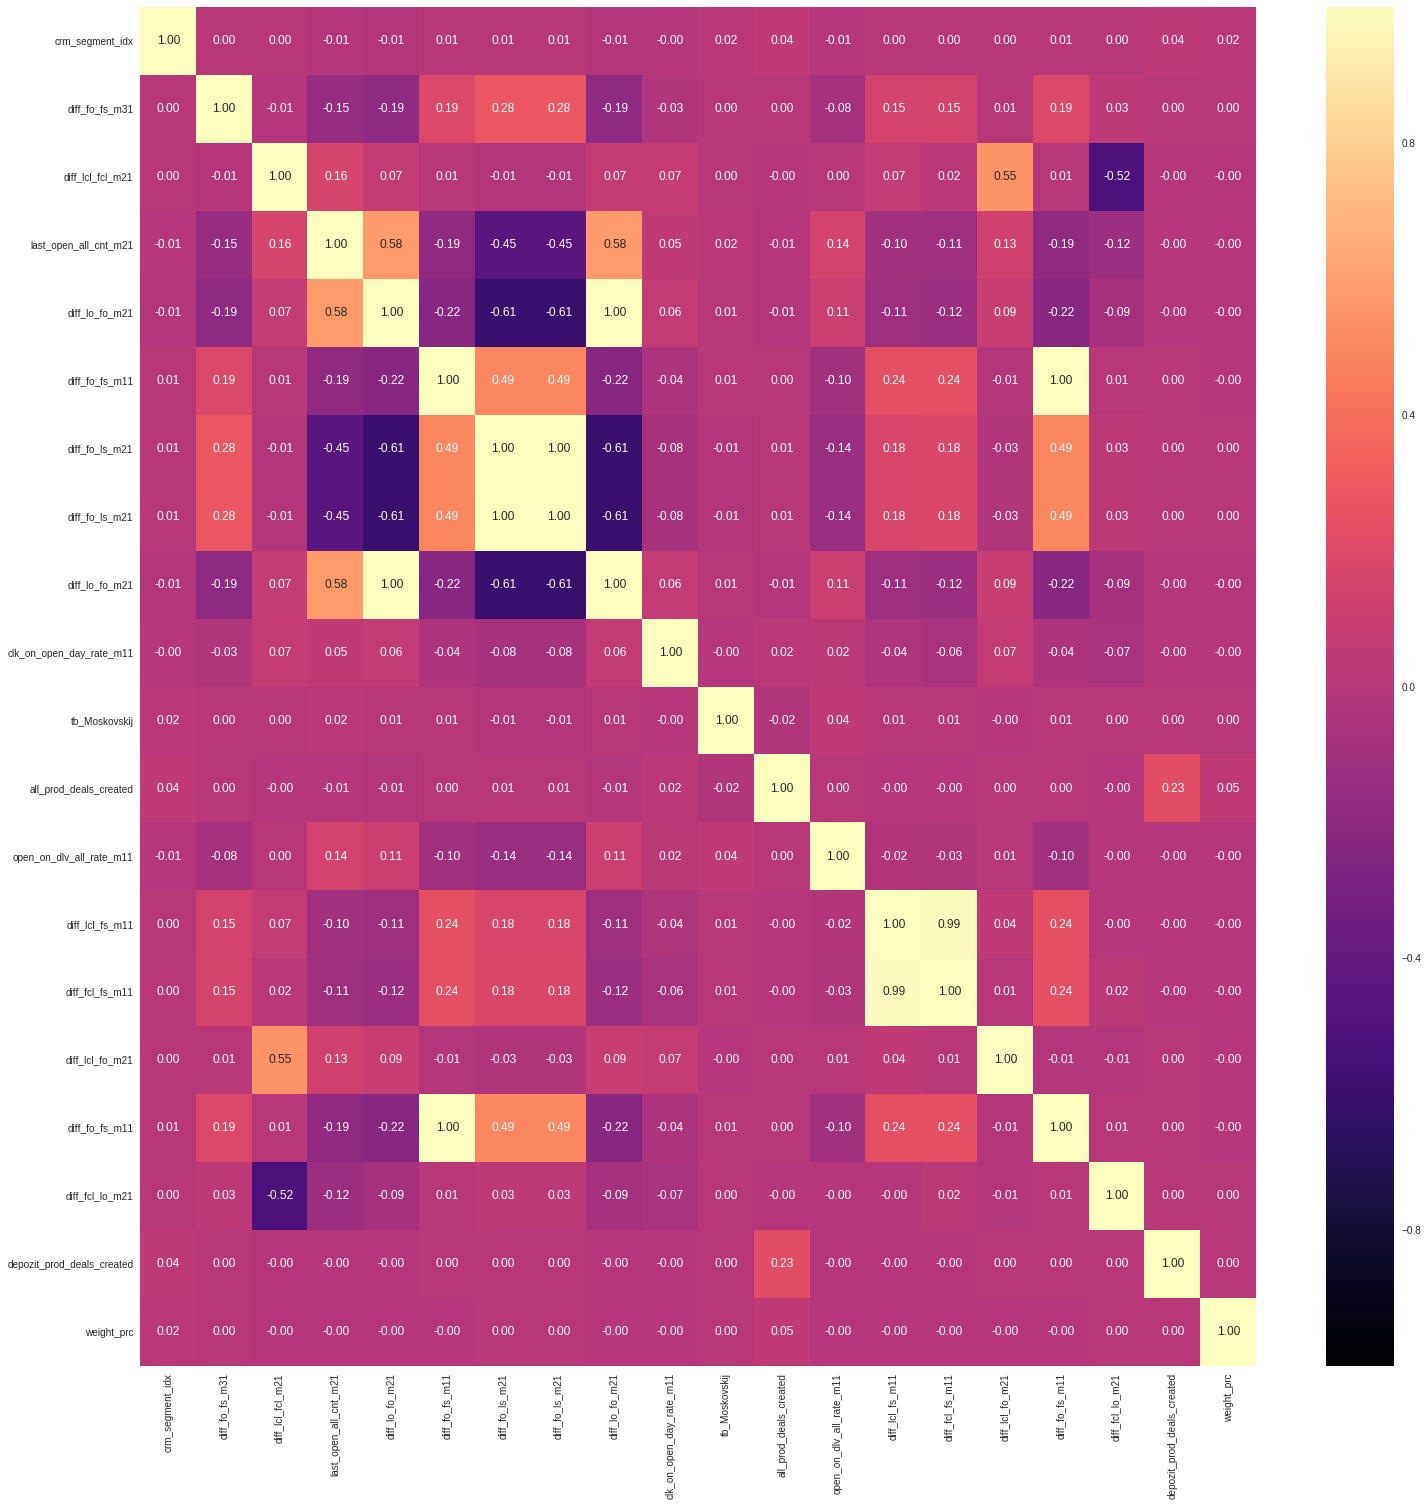

In [142]:
plt.figure(figsize=(25, 25))
sns.set()
#sns.cubehelix_palette(reverse=True, gamma=1.5, as_cmap=True) 
#sns.dark_palette((0,80,0), input='husl', as_cmap=True)
sns.heatmap(df[np.random.choice(cols_filtered, size=20)].corr(method='pearson'), 
            vmax=1, vmin=-0.7, cmap='magma', annot=True, fmt='.2f')

## XGBoost' Parameters Optimization and FineTuning

In [17]:
X_train, X_test, y_train, y_test = \
train_test_split(df.drop(['target'], axis=1), df.target, 
                 stratify = df.target,
                 random_state=42, shuffle=True, test_size=0.2)

In [19]:
classifier = XGBClassifier(random_state=42, n_jobs=40, tree_method='hist')

In [20]:
# Define parameter distribution over which to perform CV

param_dist = {
    "clf__n_estimators":                  [400, 500, 800, 1000],
    "clf__learning_rate":                 [0.005, 0.01, 0.04, 0.08],
    "clf__num_leaves":                    [64, 128, 256, 512],
    "clf__min_data_in_leaf":              [20, 50, 100, 250],
    "clf__colsample_bytree":              [0.5, 0.7, 0.8, 1.],
    "clf__scale_pos_weight":              [2.041, 1.5, 1.2, 1.],
    "clf__max_bin":                       [255, 230, 200, 180],
    "clf__max_depth":                     [5, 6, 8, 10],
    'clf__min_child_samples':             [20, 40, 100],
    'clf__min_child_weight':              [1e-5, 1e-3, 1e-2, 1e-1, 1.],
    'clf__feature_fraction':              [0.7, 0.8, 0.9, 1],
    'clf__bagging_fraction':              [0.2, 0.5, 0.8, 1.],
    'clf__bagging_freq':                  [0, 10, 20, 40],
    'clf__lambda_l1':                     [0, 1e-3, 1e-2, 1e-1],
    'clf__lambda_l2':                     [0, 1e-3, 1e-2, 1e-1],
    'clf__n_jobs':                        [20, 20, 20, 20],
    'clf__tree_method':                   ['hist', 'hist', 'hist', 'hist']
    #'clf__is_unbalance':             [True, False]
}

n_iter_search = 3 # Define number of search iterations
n_folds = 6 # Define number of CV folds

In [21]:
folds = StratifiedShuffleSplit(n_splits=n_folds, test_size=0.2)

In [22]:
pipeline = Pipeline([
    ('clf', classifier),
     ])

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=n_iter_search, cv=folds, 
                                   scoring='recall', n_jobs=7, verbose=2)

In [23]:
start = time()

random_search.fit(X_train.astype(dtype=np.float32), y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))      
print("\nBest Score = " + str(random_search.best_score_))
print("\nBest Parameters = " + str(random_search.best_params_))

Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  15 out of  18 | elapsed: 73.7min remaining: 14.7min
[Parallel(n_jobs=7)]: Done  18 out of  18 | elapsed: 74.1min finished


[06:50:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
RandomizedSearchCV took 4865.61 seconds for 3 candidates parameter settings.

Best Score = 0.34316931209926876

Best Parameters = {'clf__tree_method': 'hist', 'clf__colsample_bytree': 0.8, 'clf__n_estimators': 400, 'clf__num_leaves': 256, 'clf__min_child_samples': 100, 'clf__scale_pos_weight': 2.041, 'clf__max_depth': 6, 'clf__min_child_weight': 0.001, 'clf__max_bin': 230, 'clf__lambda_l2': 0.01, 'clf__bagging_freq': 20, 'clf__learning_rate': 0.08, 'clf__lambda_l1': 0.01, 'clf__n_jobs': 20, 'clf__min_data_in_leaf': 50, 'clf__bagging_fraction': 1.0, 'clf__feature_fraction': 0.9}


### Fit cls with the best params selected

In [24]:
classifier = pipeline.set_params(clf__n_estimators                 = random_search.best_params_['clf__n_estimators'],
                                 clf__learning_rate                = random_search.best_params_['clf__learning_rate'],
                                 clf__num_leaves                   = random_search.best_params_['clf__num_leaves'],
                                 clf__max_bin                      = random_search.best_params_['clf__max_bin'],
                                 clf__max_depth                    = random_search.best_params_['clf__max_depth'],
                                 clf__scale_pos_weight             = random_search.best_params_['clf__scale_pos_weight'],
                                 clf__colsample_bytree             = random_search.best_params_['clf__colsample_bytree'],                                 
                                 clf__min_child_samples            = random_search.best_params_['clf__min_child_samples'],
                                 clf__min_data_in_leaf             = random_search.best_params_['clf__min_data_in_leaf'],
                                 clf__min_child_weight             = random_search.best_params_['clf__min_child_weight'],
                                 clf__feature_fraction             = random_search.best_params_['clf__feature_fraction'],
                                 clf__bagging_fraction             = random_search.best_params_['clf__bagging_fraction'],
                                 clf__bagging_freq                 = random_search.best_params_['clf__bagging_freq'],
                                 clf__lambda_l1                    = random_search.best_params_['clf__lambda_l1'],
                                 clf__lambda_l2                    = random_search.best_params_['clf__lambda_l2'],
                                 clf__n_jobs                       = 40,
                                 clf__tree_method                  = random_search.best_params_['clf__tree_method']                                 
                                 )

In [25]:
classifier.fit(X_train.astype(dtype=np.float32), y_train)

[07:49:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(bagging_fraction=1.0, bagging_freq=20,
                               base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=0.8,
                               feature_fraction=0.9, gamma=0, lambda_l1=0.01,
                               lambda_l2=0.01, learning_rate=0.08, max_bin=230,
                               max_delta_step=0, max_depth=6,
                               min_child_samples=100, min_child_weight=0.001,
                               min_data_in_leaf=50, missing=None,
                               n_estimators=400, n_jobs=40, nthread=None,
                               num_leaves=256, objective='binary:logistic',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=2.041, seed=None, silent=True,
                               subsample=1, ...))],
         verbose=False)

In [26]:
y_pred = classifier.predict(X_test.astype(dtype=np.float32))

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.88973   0.93780   0.91313   1067912
           1    0.49353   0.34275   0.40454    188848

    accuracy                        0.84838   1256760
   macro avg    0.69163   0.64027   0.65884   1256760
weighted avg    0.83019   0.84838   0.83671   1256760

Hold Out: 
Precision: 0.49353, Recall: 0.34275, F_1: 0.40454


In [27]:
joblib.dump(classifier, './pkl/xgb_cls_tuned_pipe_wFT_200820.pkl')

['./pkl/xgb_cls_tuned_pipe_wFT_200820.pkl']

## Probabilities Calibration

In [77]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [96]:
xgb = classifier['clf']

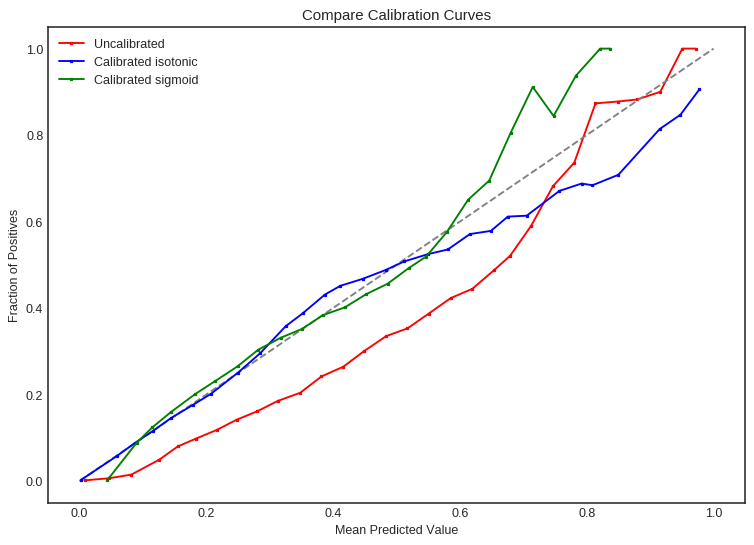

In [79]:
# use CalibratedClassifierCV with sigmoid and isotonic parameters

plt.figure(figsize=(10,7), dpi=90)
plt.style.use('seaborn-white')

fraction_of_pos, mean_pred_val = calibration_curve(y_test, y_proba, n_bins=30)
plt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color='red', label='Uncalibrated')
plt.plot([0,1],[0,1],'--',color='gray')

methodlst=['isotonic','sigmoid',]
clr=['blue','green']
i=0
for method in methodlst:
    clf_calib=CalibratedClassifierCV(xgb, cv='prefit', method=method, xdtype=pd.core.frame.DataFrame)
  
    try:
        clf_calib.fit(X_train.astype(dtype=np.float32), y_train.astype(dtype=np.float32))
    except ValueError as err:
        print("Cols mismatched... Try to catch cols order from error message-->")
        colsstr     = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
        getcolslist = list(ast.literal_eval(colsstr[1:-1]))
        _X_train = X_train[getcolslist].astype(dtype=np.float32)
        clf_calib.fit(_X_train, y_train)
        
    y_tst_clf_calib_proba=clf_calib.predict_proba(X_test.astype(dtype=np.float32))[:,1]
    fraction_of_pos, mean_pred_val = calibration_curve(y_test, y_tst_clf_calib_proba, n_bins=30)
    plt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color=clr[i], label='Calibrated %s' % method)
    i=i+1
    
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')
plt.title('Compare Calibration Curves')
plt.show()

## Choose Sogmoid Method and obtain recalibated proba

In [84]:
methodlst=['sigmoid']
for method in methodlst:
    clf_calib=CalibratedClassifierCV(xgb, cv='prefit', method=method, xdtype=pd.core.frame.DataFrame)
  
    try:
        clf_calib.fit(X_train.astype(dtype=np.float32), y_train.astype(dtype=np.float32))
    except ValueError as err:
        print("Cols mismatched... Try to catch cols order from error message-->")
        colsstr     = str(err).split('feature_names mismatch: ')[1].split(' [')[0]
        getcolslist = list(ast.literal_eval(colsstr[1:-1]))
        _X_train = X_train[getcolslist].astype(dtype=np.float32)
        clf_calib.fit(_X_train, y_train)
        
    y_tst_clf_calib_proba=clf_calib.predict_proba(X_test.astype(dtype=np.float32))[:,1]

In [85]:
# classification report after recalibration of proba
threshold=0.5
y_pred = binarize(y_tst_clf_calib_proba.reshape(-1, 1), threshold=threshold).reshape(-1)

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.88000   0.95667   0.91674   1067912
           1    0.51705   0.26232   0.34806    188848

    accuracy                        0.85233   1256760
   macro avg    0.69853   0.60949   0.63240   1256760
weighted avg    0.82546   0.85233   0.83128   1256760

Hold Out: 
Precision: 0.51705, Recall: 0.26232, F_1: 0.34806


In [86]:
joblib.dump(clf_calib,'./pkl/CalibratedClassifierCV_xgb_200820.pkl')

['./pkl/CalibratedClassifierCV_xgb_200820.pkl']

## Find Pr/Re curves Intersection and set a new threshold for logits binarization

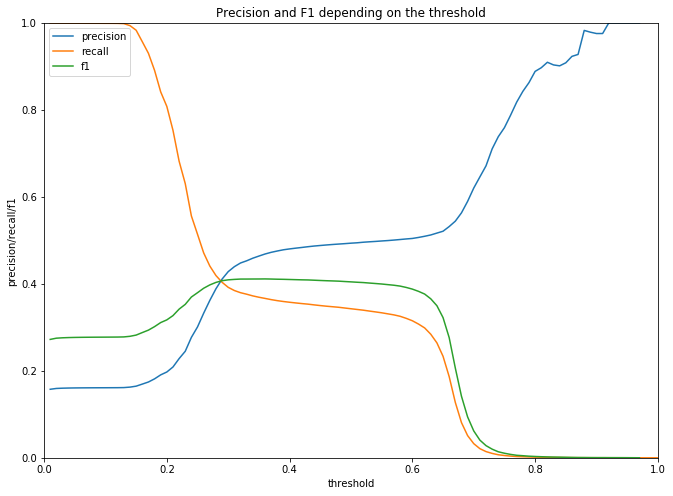

In [67]:
y_proba = classifier.predict_proba(X_test.astype(dtype=np.float32))[:,1]
re, pr, f1 = Plot.precision_recall_threshold_curve(y_test, y_proba)

In [53]:
thresholds = np.arange(0.01, 1.05, 0.01)

In [71]:
print('Pr/Re Cross point value: ', '%0.3f' % pr[np.argwhere(np.isclose(re, pr, atol=0.02)).ravel()[0]])

Pr/Re Cross point value:  0.411


In [72]:
# Pr/Re intersection point
intersec_arg = np.argwhere(np.isclose(re, pr, atol=0.02)).ravel()[0]
# intersec_arg, pr[intersec_arg]
print('Pr/Re Cross point thresholds value: ', '%0.3f' % intersec_arg)

Pr/Re Cross point thresholds value:  28.000


In [55]:
# point at which F1 becomes maximum
f1_max_indx = np.argwhere(np.array(f1) == np.array(f1)[~np.isnan(f1)].max()).ravel()[0]
f1_max_indx

35

In [63]:
# choose an average threshold point in order to maximize Re but not to degrage Pr simultaneosly 
avg_indx =f1_max_indx + np.round(0.97*(intersec_arg - f1_max_indx )).astype(int)
avg_indx

28

In [64]:
y_pred = binarize(y_proba.reshape(-1, 1), threshold=thresholds[avg_indx]).reshape(-1)
recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))

              precision    recall  f1-score   support

           0    0.89487   0.89769   0.89627   1067912
           1    0.41093   0.40361   0.40724    188848

    accuracy                        0.82344   1256760
   macro avg    0.65290   0.65065   0.65176   1256760
weighted avg    0.82215   0.82344   0.82279   1256760



In [87]:
# classification report after recalibration of proba
threshold=thresholds[avg_indx]
y_pred = binarize(y_tst_clf_calib_proba.reshape(-1, 1), threshold=threshold).reshape(-1)

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.89056   0.93501   0.91225   1067912
           1    0.48799   0.35027   0.40782    188848

    accuracy                        0.84714   1256760
   macro avg    0.68928   0.64264   0.66003   1256760
weighted avg    0.83007   0.84714   0.83645   1256760

Hold Out: 
Precision: 0.48799, Recall: 0.35027, F_1: 0.40782


In [58]:
average_precision_score(y_test, y_proba)

0.3596522029116522

## Permutation Importance with Forward Feature Selection+CV

In [50]:
for file in os.listdir('./pkl'):
    if 'xgb_cls_tuned_pipe_wFT_200820' in file:
        print("...load xgb model from--> {}".format(file))
        xgb = joblib.load('./pkl/{}'.format(file))

...load xgb model from--> xgb_cls_tuned_pipe_wFT_200820.pkl


In [19]:
import re
pattern = re.compile(r'.*_m\d{1}1')
ftcols = [col for col in list(df.columns) if '_FT_' in col]
respcols = [col for col in list(df.columns) if len(pattern.findall(col))!=0]
ml360cols = list(set(list(df.columns)) - set(respcols) - set(ftcols))

cols_filtered = list(set(respcols+ml360cols)-set(['target']))

In [20]:
X_train[cols_filtered].shape

(5027040, 105)

In [21]:
frwPerm = ForwardPermutationFECV(metric='recall', n_jobs=50, n_folds=5, folds='StratifiedKFold')

In [ ]:
#threshold =0.5
frwPerm.fit_transform(X_train[cols_filtered], y_train, xgb['clf'], isfit=False)

## Check Permutation Importance Matrix

In [28]:
frwPerm.permutation_importance_df.head(30)

,features,permutation_recall,permutation_recall_1,permutation_recall_2,permutation_recall_3,permutation_recall_4,permutation_mean
14,last_open_all_cnt_m11,0.235124,0.228730,0.250109,0.231682,0.236280,0.236385
58,last_open_day_cnt_m11,0.222163,0.235534,0.227598,0.226717,0.229628,0.228328
98,last_open_all_cnt_m21,0.126445,0.130740,0.122619,0.124955,0.127682,0.126488
94,last_click_all_cnt_m11,0.024822,0.030097,0.032314,0.029376,0.029521,0.029226
91,open_on_dlv_day_rate_m11,0.016601,0.016852,0.016170,0.017203,0.016395,0.016644
13,open_on_dlv_all_rate_m11,0.017210,0.013841,0.014655,0.014112,0.015475,0.015058
35,diff_lo_fo_m11,0.012139,0.011067,0.013066,0.012206,0.014377,0.012571
55,prior_true_idx,0.011630,0.011881,0.011577,0.012014,0.012100,0.011840
51,diff_lo_fo_m21,0.009637,0.009968,0.010180,0.010471,0.009948,0.010041
88,diff_lo_ls_m11,0.008400,0.009326,0.011590,0.009392,0.010339,0.009809


In [30]:
frwPerm.permutation_importance_df.loc[frwPerm.permutation_importance_df['permutation_mean'] > 0,'features'].count()

78

## Forward Selection Fit based on the positive values of Permutation Importance Matrix

In [ ]:
frwPerm.epsilon = 0.0015
main_import_feat = frwPerm.fit_transform(X_train[cols_filtered], y_train, xgb, isfit=True)

In [43]:
main_import_feat

['last_open_all_cnt_m11',
 'last_open_day_cnt_m11',
 'last_open_all_cnt_m21',
 'last_click_all_cnt_m11',
 'open_on_dlv_day_rate_m11',
 'open_on_dlv_all_rate_m11',
 'diff_lo_fo_m11',
 'prior_true_idx',
 'diff_lo_fo_m21',
 'diff_lo_ls_m11',
 'last_open_all_cnt_m31',
 'last_open_day_cnt_m21',
 'salary_prod_deals_created',
 'diff_lo_ls_m21',
 'corp_cards_prod_deals_completed',
 'open_on_dlv_all_rate_m21',
 'diff_fo_ls_m21',
 'diff_lo_fs_m11',
 'corp_cards_prod_deals_created']

## Train Previously Fine-Tuned Xgboost on dataset with selected features after copletion of Features Permutation process

### With FastText

In [53]:
xgb.fit(X_train[main_import_feat+ftcols].astype(dtype=np.float32), y_train)

[14:36:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(bagging_fraction=1.0, bagging_freq=20,
                               base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=0.8,
                               feature_fraction=0.9, gamma=0, lambda_l1=0.01,
                               lambda_l2=0.01, learning_rate=0.08, max_bin=230,
                               max_delta_step=0, max_depth=6,
                               min_child_samples=100, min_child_weight=0.001,
                               min_data_in_leaf=50, missing=nan,
                               n_estimators=400, n_jobs=40, nthread=None,
                               num_leaves=256, objective='binary:logistic',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=2.041, seed=None, silent=True,
                               subsample=1, ...))],
         verbose=False)

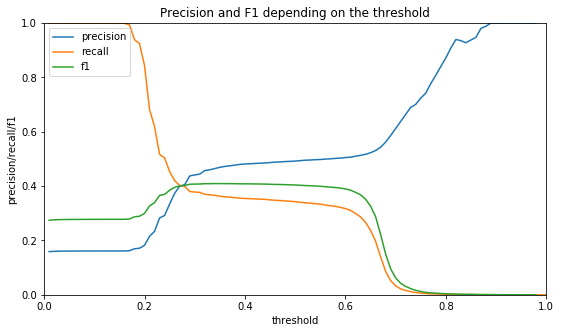

In [54]:
y_proba = xgb.predict_proba(X_test[main_import_feat+ftcols].astype(dtype=np.float32))[:,1]
re, pr, f1 = Plot.precision_recall_threshold_curve(y_test, y_proba)

In [55]:
thresholds = np.arange(0.01, 1.05, 0.01)

# Pr/Re intersection point
intersec_arg = np.argwhere(np.isclose(re, pr, atol=0.02)).ravel()[0]
# intersec_arg, pr[intersec_arg]
print('Pr/Re Cross point thresholds value: ', '%0.3f' % intersec_arg)
# point at which F1 becomes maximum
f1_max_indx = np.argwhere(np.array(f1) == np.array(f1)[~np.isnan(f1)].max()).ravel()[0]
# choose an average threshold point in order to maximize Re but not to degrage Pr simultaneosly 
avg_indx = f1_max_indx + np.round(0.97*(intersec_arg - f1_max_indx )).astype(int)

threshold=thresholds[avg_indx]
y_pred = binarize(y_proba.reshape(-1, 1), threshold=threshold).reshape(-1)

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

Pr/Re Cross point thresholds value:  26.000
              precision    recall  f1-score   support

           0    0.89418   0.89308   0.89363   1067912
           1    0.39957   0.40234   0.40095    188848

    accuracy                        0.81934   1256760
   macro avg    0.64688   0.64771   0.64729   1256760
weighted avg    0.81986   0.81934   0.81960   1256760

Hold Out: 
Precision: 0.39957, Recall: 0.40234, F_1: 0.40095


### Without FastText

In [56]:
xgb.fit(X_train[main_import_feat].astype(dtype=np.float32), y_train)

[14:52:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


Pipeline(memory=None,
         steps=[('clf',
                 XGBClassifier(bagging_fraction=1.0, bagging_freq=20,
                               base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=0.8,
                               feature_fraction=0.9, gamma=0, lambda_l1=0.01,
                               lambda_l2=0.01, learning_rate=0.08, max_bin=230,
                               max_delta_step=0, max_depth=6,
                               min_child_samples=100, min_child_weight=0.001,
                               min_data_in_leaf=50, missing=nan,
                               n_estimators=400, n_jobs=40, nthread=None,
                               num_leaves=256, objective='binary:logistic',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=2.041, seed=None, silent=True,
                               subsample=1, ...))],
         verbose=False)

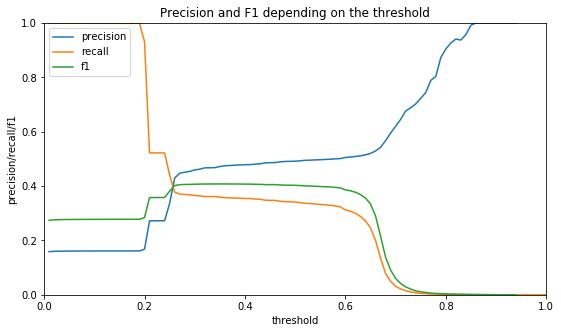

In [57]:
y_proba = xgb.predict_proba(X_test[main_import_feat].astype(dtype=np.float32))[:,1]
re, pr, f1 = Plot.precision_recall_threshold_curve(y_test, y_proba)

In [61]:
thresholds = np.arange(0.01, 1.05, 0.01)

# Pr/Re intersection point
intersec_arg = np.argwhere(np.isclose(re, pr, atol=0.1)).ravel()[0]
# intersec_arg, pr[intersec_arg]
print('Pr/Re Cross point thresholds value: ', '%0.3f' % intersec_arg)
# point at which F1 becomes maximum
f1_max_indx = np.argwhere(np.array(f1) == np.array(f1)[~np.isnan(f1)].max()).ravel()[0]
# choose an average threshold point in order to maximize Re but not to degrage Pr simultaneosly 
avg_indx = f1_max_indx + np.round(0.97*(intersec_arg - f1_max_indx )).astype(int)

threshold=thresholds[avg_indx]
y_pred = binarize(y_proba.reshape(-1, 1), threshold=threshold).reshape(-1)

recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
                                                  
print('Hold Out: ')
print('Precision: %7.5f, Recall: %7.5f, F_1: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

Pr/Re Cross point thresholds value:  25.000
              precision    recall  f1-score   support

           0    0.89224   0.91123   0.90164   1067912
           1    0.42934   0.37768   0.40186    188848

    accuracy                        0.83105   1256760
   macro avg    0.66079   0.64446   0.65175   1256760
weighted avg    0.82268   0.83105   0.82654   1256760

Hold Out: 
Precision: 0.42934, Recall: 0.37768, F_1: 0.40186


## Incremental UPTraining

In [7]:
for file in os.listdir('./pkl'):
    if 'xgb_cls_tuned_pipe_wFT_200820' in file:
        print("...load xgb model from--> {}".format(file))
        xgb = joblib.load('./pkl/{}'.format(file))

xgb_params = xgb.get_params()
xgb_params = dict(xgb_params,**{'n_jobs'   : 15,
                                'verbosity': 1})

...load xgb model from--> xgb_cls_tuned_pipe_wFT_200820.pkl


In [8]:
%%time
num_part = 3
filelist = list(set(filelist) - set(['df_cols']))
batches = np.array_split(np.arange(len(filelist)),num_part)
cls = XGBClassifier(**xgb_params)

for batch in tqdm_notebook(batches, total=len(batches)):
    
    df = pd.read_csv(filepath_or_buffer = path+filelist[1], 
                     sep = ';', nrows=0, 
                     engine='python',
                     dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                     )     
    
    items = list(map(filelist.__getitem__,batch))
    for i, data in tqdm_notebook(enumerate(items), total=len(items)):
        if data.endswith('csv'):
            print("...working with file--> {}".format(data))
            dftmp = pd.read_csv(filepath_or_buffer = path+data, 
                             sep = ';', nrows=None, 
                             engine='python',
                             dtype = dict({col: np.float32 for col in cols if col not in ('target')}, **{'target' : np.int32})
                             ) 
            
            df = pd.concat([df,dftmp], ignore_index=True)
            del dftmp            

    zero_std_cols = df.columns[df.std(axis=0) == 0.].values.tolist()
    df.drop(columns=zero_std_cols, axis=1, inplace=True)


    print("...Start of incremental training #{}".format(i)) 
    X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(['target'], axis=1), df.target,
                     stratify = df.target,
                     random_state=42, shuffle=True, test_size=0.1)

    xgb_params = dict(xgb_params,**{'n_jobs'   : 45,
                                    'verbosity': 1,
                                    'update':'refresh',
                                    'process_type':'default',
                                    'refresh_leaf':True,                                    
                                    'xgb_model': cls})

    del df
    gc.collect()

#     X_train = X_train.astype(dtype=np.float32)
    cls = XGBClassifier(**xgb_params)  
    cls.fit(X_train, y_train)

    del X_train, y_train
    gc.collect()

    print("...End of incremental training #{}".format(i))
    print("#"*60)   
    X_test = X_test.astype(dtype=np.float32)
    y_proba = cls.predict_proba(X_test)[:,1]

    del X_test
    gc.collect()

    y_pred = binarize(y_proba.reshape(-1, 1), threshold=0.28).reshape(-1)
    recall_ts, precision_ts, f1_ts =  get_metrics(y_pred.astype(int), y_test.astype(int))
    print('Hold Out: ')
    print("Precision: {:7.5f}, Recall: {:7.5f}, F_1: {:7.5f}".format(precision_ts, recall_ts, f1_ts))
    print("#"*60)

    del y_test, y_pred
    gc.collect()

...working with file--> part-00000-2d03538f-8fa5-4167-a3d3-892d5d91fc11-c000.csv
...working with file--> part-00000-84586571-0a34-4fe6-a69d-5fc728f32ca9-c000.csv
...working with file--> part-00000-337a96d8-98ce-4233-8ac2-5cfe844b5136-c000.csv
...working with file--> part-00000-13989770-51d9-4a34-9486-f082520796ad-c000.csv

...Start of incremental training #3
...End of incremental training #3
############################################################
              precision    recall  f1-score   support

           0    0.88890   0.92954   0.90877    213613
           1    0.46193   0.34238   0.39327     37739

    accuracy                        0.84138    251352
   macro avg    0.67541   0.63596   0.65102    251352
weighted avg    0.82479   0.84138   0.83137    251352

Hold Out: 
Precision: 0.46193, Recall: 0.34238, F_1: 0.39327
############################################################


...working with file--> part-00000-a9770f0a-e8c6-43ae-854d-cd04c12522a4-c000.csv
...working with file--> part-00000-b7624993-460a-40c2-966f-65b791eb9f35-c000.csv
...working with file--> part-00000-bcd86821-0ebe-40d9-a2a9-e680a055186c-c000.csv

...Start of incremental training #2
...End of incremental training #2
############################################################
              precision    recall  f1-score   support

           0    0.88832   0.92956   0.90847    160179
           1    0.46014   0.33939   0.39065     28336

    accuracy                        0.84085    188515
   macro avg    0.67423   0.63448   0.64956    188515
weighted avg    0.82396   0.84085   0.83064    188515

Hold Out: 
Precision: 0.46014, Recall: 0.33939, F_1: 0.39065
############################################################


...working with file--> part-00000-05b80dce-e559-4fcc-b46d-c21e8755fdcd-c000.csv
...working with file--> part-00000-5799ae44-0b33-460d-9690-09856f9ae02b-c000.csv
...working with file--> part-00000-70b4cb69-d6ab-4d11-9948-cda8eb654782-c000.csv

...Start of incremental training #2
...End of incremental training #2
############################################################
              precision    recall  f1-score   support

           0    0.88955   0.93028   0.90946    160165
           1    0.46867   0.34742   0.39904     28349

    accuracy                        0.84263    188514
   macro avg    0.67911   0.63885   0.65425    188514
weighted avg    0.82626   0.84263   0.83270    188514

Hold Out: 
Precision: 0.46867, Recall: 0.34742, F_1: 0.39904
############################################################

CPU times: user 3h 17min 53s, sys: 16min 33s, total: 3h 34min 27s
Wall time: 1h 3min 54s
